In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from torchvision.transforms.functional import resize

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 2060


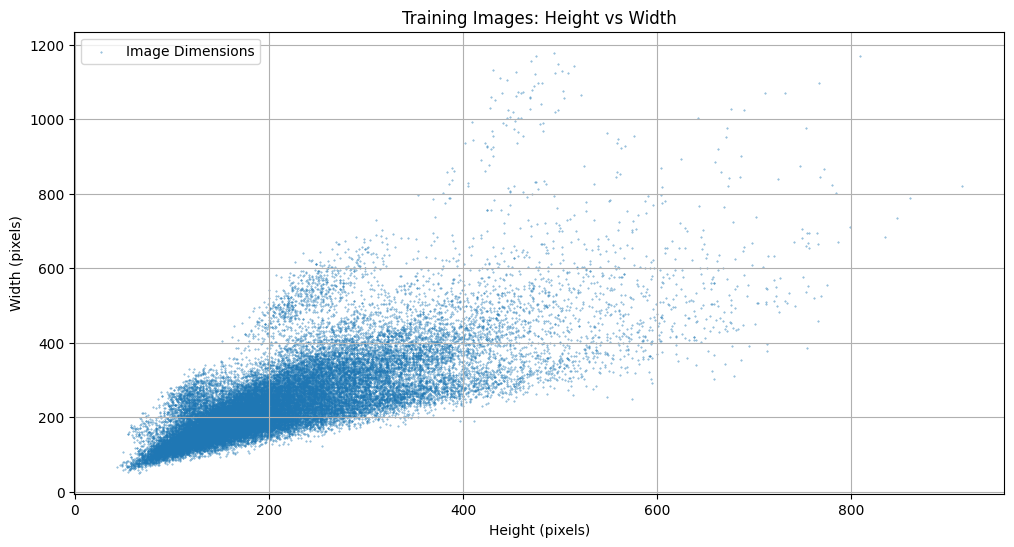

In [3]:
def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def collect_dimensions(image_dir):
    dimensions = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                dimensions.append(result)

    return dimensions

def plot_histogram(dimensions, title):
    heights = [dim[1] for dim in dimensions]
    widths = [dim[0] for dim in dimensions]

    plt.figure(figsize=(12, 6))
    plt.scatter(heights, widths, alpha=0.7, s=0.15, label="Image Dimensions")  # Adjusted s parameter for smaller dots
    plt.title(title)
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_dir = r"D:\\Computer Vision\\FYP\\TASK 1\\env\\TrackNet-X\\DataSet\\VeRi\\image_train"

train_dimensions = collect_dimensions(train_dir)

if train_dimensions:
    plot_histogram(train_dimensions, "Training Images: Height vs Width")
else:
    print("No dimensions collected for training images.")

In [4]:
width = 256
height = 196

In [5]:
class BaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory containing images.
            transform (callable, optional): Transformations applied to images.
        """
        self.root_dir = root_dir
        self.transform = transform

        # List all image files and extract labels
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.labels = [int(img.split('_')[0]) for img in os.listdir(root_dir)]  # Extract ID (first part of filename)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


class TripletDataset(Dataset):
    def __init__(self, base_dataset):
        """
        Wraps around BaseDataset to generate triplets (anchor, positive, negative).
        """
        self.base_dataset = base_dataset
        self.data_by_label = self._group_by_label()

    def _group_by_label(self):
        """
        Groups indices of images by their labels.
        """
        data_by_label = {}
        for idx, (_, label) in enumerate(self.base_dataset):
            data_by_label.setdefault(label, []).append(idx)
        return data_by_label

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.base_dataset[idx]

        # Positive sample (same label)
        positive_idx = random.choice(self.data_by_label[anchor_label])
        while positive_idx == idx:  # Ensure positive != anchor
            positive_idx = random.choice(self.data_by_label[anchor_label])
        positive_img, _ = self.base_dataset[positive_idx]

        # Negative sample (different label)
        negative_label = random.choice([lbl for lbl in self.data_by_label if lbl != anchor_label])
        negative_idx = random.choice(self.data_by_label[negative_label])
        negative_img, _ = self.base_dataset[negative_idx]

        return anchor_img, positive_img, negative_img

In [6]:
class TripletCNN(nn.Module):
    def __init__(self):
        super(TripletCNN, self).__init__()

        # First convolution layer
        self.conv1 = nn.Conv2d(3, 12, kernel_size=7, stride=5, padding=3)
        self.pool1 = nn.MaxPool2d(2, 1)  # Max pooling

        # Second convolution layer
        self.conv2 = nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1)

        # Third convolution layer
        self.conv3 = nn.Conv2d(24, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsampling

        # Fourth convolution layer
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Global pooling and fully connected layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = F.relu(self.conv4(x))
        x = self.global_pool(x)
        x = self.fc(x)

        return x

In [7]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((196, 256)),  # Resize to 196x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to dataset
data_path = r"D:\\Computer Vision\\FYP\\TASK 1\\env\\TrackNet-X\\DataSet\\VeRi\\image_train"

# Initialize datasets
base_dataset = BaseDataset(root_dir=data_path, transform=transform)
triplet_dataset = TripletDataset(base_dataset)

# DataLoader
train_loader = DataLoader(triplet_dataset, batch_size=16, shuffle=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TripletCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss_fn = nn.TripletMarginLoss(margin=3.0)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):  # Number of epochs
    model.train()
    epoch_loss = 0

    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        # Forward pass
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)

        # Compute triplet loss
        loss = triplet_loss_fn(anchor_embed, positive_embed, negative_embed)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Save the trained model
model_path = "triplet_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Epoch 1/10, Loss: 1.4172662683178265
Epoch 2/10, Loss: 1.0219732180464884
Epoch 3/10, Loss: 0.8834921286065229
Epoch 4/10, Loss: 0.8046705877245937
Epoch 5/10, Loss: 0.7485773168901687
Epoch 6/10, Loss: 0.6824981102390273
Epoch 7/10, Loss: 0.6259981426871701
Epoch 8/10, Loss: 0.608019239828306
Epoch 9/10, Loss: 0.5895334259243359
Epoch 10/10, Loss: 0.5562706043743462
Model saved to triplet_cnn_model.pth


In [20]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TripletCNN(nn.Module):
    def __init__(self):
        super(TripletCNN, self).__init__()
        # CNN definition (same as previously used)
        self.conv1 = nn.Conv2d(3, 12, 7, stride=5, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(12, 24, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(24, 32, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.global_pool(x)
        x = self.fc(x)
        return x

# Load the trained model weights
model = TripletCNN().to(device)
model.load_state_dict(torch.load("triplet_cnn_model.pth"))
model.eval()

# Image transformation (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((196, 256)),  # Height, Width
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to extract embedding
def extract_embedding(image_path, model, device):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        embedding = model(image)
    return embedding

# Function to check similarity between two images
def check_similarity(image_path1, image_path2, model, device, threshold=0.5):
    embedding1 = extract_embedding(image_path1, model, device)
    embedding2 = extract_embedding(image_path2, model, device)
    
    # Compute cosine similarity
    similarity = F.cosine_similarity(embedding1, embedding2).item()
    print(f"Cosine Similarity: {similarity:.4f}")

    # Decision
    if similarity > threshold:
        print("The images are of the SAME car.")
    else:
        print("The images are of DIFFERENT cars.")

# Example usage
image_path1 = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\anchor.jpg' # Replace with car image 1 path
image_path2 = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\0 (1).jpg'# Replace with car image 2 path

check_similarity(image_path1, image_path2, model, device, threshold=0.5)

Cosine Similarity: 0.9613
The images are of the SAME car.


C:\Users\ahmad\AppData\Local\Temp\ipykernel_8080\1529222140.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("triplet_cnn_model.pth"))


In [13]:
model_path = "triplet_cnn_model.pth"
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Function to preprocess images
def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return img

def compute_distance(model, image1_path, image2_path, transform, margin=3.0, device='cpu'):
    image1 = preprocess_image(image1_path, transform).to(device)
    image2 = preprocess_image(image2_path, transform).to(device)
    
    with torch.no_grad():
        feature1 = model(image1)
        feature2 = model(image2)
    
    distance = F.pairwise_distance(feature1, feature2,p=2).item()
    similarity = distance < margin
    
    if similarity:
        print(f"Images are similar (distance: {distance:.4f})")
    else:
        print(f"Images are different (distance: {distance:.4f})")
    
    return distance, similarity

def main():

    image1_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\anchor.jpg'
    image2_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\1 (6).jpg'
    
    transform = transforms.Compose([transforms.Resize((196, 196)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    model = TripletCNN().to(device)
    model = load_model(model, model_path)
    
    distance, similarity = compute_distance(model, image1_path, image2_path, transform, margin=3.0, device=device)

if __name__ == "__main__":
    main()

Images are different (distance: 6.6693)


C:\Users\ahmad\AppData\Local\Temp\ipykernel_8080\2317001202.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=tor

In [10]:
from sklearn.metrics import confusion_matrix
import numpy as np

def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    return img

def compute_distance(model, image1_path, image2_path, transform, margin=5.0, device='cpu'):
    image1 = preprocess_image(image1_path, transform).to(device)
    image2 = preprocess_image(image2_path, transform).to(device)
    
    with torch.no_grad():
        feature1 = model(image1)
        feature2 = model(image2)
    
    distance = F.pairwise_distance(feature1, feature2, p=2).item()
    similarity = distance < margin
    
    return distance, similarity

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest'
anchor_path = os.path.join(dir, 'anchor.jpg')

transform = transforms.Compose([transforms.Resize((220, 220)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

model = TripletCNN().to('cpu')
model = load_model(model, model_path)

y_true = []
y_pred = []

for filename in os.listdir(dir):
    if filename == 'anchor.jpg':
        continue
    image_path = os.path.join(dir, filename)
    label = int(filename.split(' ')[0]) 
    _, similarity = compute_distance(model, anchor_path, image_path, transform, margin=5.0, device='cpu')
    
    y_true.append(label)
    y_pred.append(1 if similarity else 0)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

C:\Users\ahmad\AppData\Local\Temp\ipykernel_8080\1922074997.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

Confusion Matrix:
[[10  0]
 [ 9  1]]
